# Part 0: Import and Preference settings

In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random

from nltk.corpus import stopwords

In [2]:
# Set options

%matplotlib inline
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [3]:
# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Specify data directory

data_dir = os.path.join(os.path.dirname(os.getcwd()),'Data')

In [5]:
# Set data paths

train_path = os.path.join(data_dir, 'train.csv')

train_processed_path = os.path.join(data_dir, 'interim', 'train_preprocessed.txt')

In [6]:
# Read datasets

train = pd.read_csv(train_path)
train_processed = pd.read_json(train_processed_path)

In [7]:
train.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


# Part 1: Exploratory Data Analysis

In [8]:
train.sentiment.value_counts(sort = False)

0     617
1     837
2    3825
Name: sentiment, dtype: int64

## Count of Each Sentiment class

First, we take a look at the review counts for each sentiment:

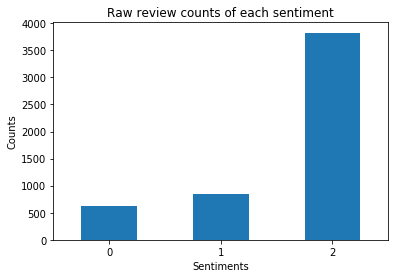

In [9]:
# Find sentiment class seperation

train.sentiment.value_counts(sort = False).plot(kind = 'bar', rot = 0)
plt.title('Raw review counts of each sentiment')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.show()

<div class="span5 alert alert-success">
It looks as if our sample display high imbalance. We must take a mental note to explore techniques of resampling or tuning better metrics to improve our model's generality.
</div>

## Take a glimpse into random reviews

In [10]:
pos_index = train[train.sentiment == 0].index.tolist()
neg_index = train[train.sentiment == 1].index.tolist()
neu_index = train[train.sentiment == 2].index.tolist()

In [11]:
train[train.sentiment == 1].text[random.sample(neg_index,1)].values

array(['So, I was diagnosed with mild UC November 2016, and ever since that I have only gone downhill. Humira did nothing for me, and I’m trying to get approval for entyvio. Lately I get up like 5-6 times a night to go to the bathroom, and it’s getting ridiculous. I find that if I’m sleeping on one side, and quickly shift to the other I have to run to the bathroom. It’s like my colon is sleeping and if I shift over to the other side I just woke it up. Anyone else deal with this? Just had my 3rd colonoscopy, and now it’s severe UC. If that helps anything'],
      dtype=object)

<div class="span5 alert alert-success">
<b>Insight:</b>
<ul>
    <li>Many of the reviews compare drugs, thus has several drug name mentioned .. Bag of word would experience confusion over this. I don't think removing the name of all drugs is a good idea since qualities of other classes would be attached to the drug in question.</li>
    <li>Would a feature like how many drugs mention work?</li>
    <li>Some reviews have sarcasm</li>
    <li>Some reviews compare between 2 drugs</li>
    <li>Seems that review lengths are associated with sentiments, I'll have to check this</li>
    <li>There were some emoticons, could that help?</li>
</ul>
It's clear that we might do well with extracted meta-data
</div>

## Transforming and Extracting Meta Data

In [12]:
# Defining and transforming function to extract meta-data
STOPWORDS = set(stopwords.words('english'))
                
def extract_meta_data(data):
    df = data.copy()
    
    # Extract the list of all drugs
    drug_list = data.drug.unique().tolist()
    
    # Extract the drug mention count
    df['drug_count'] = df['text'].apply(lambda x: len(np.intersect1d(x.lower().split(),drug_list)))
    
    # Extract whether the text has upper-cased letters
    # df["has_upper"] = df["text"].apply(lambda x: x.lower() != x).map({True:1,False:0})
    
    # Extract the number uppercased letter
    df['n_upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    
    # Extract the word count of each row
    df['word_count']=df['text'].apply(lambda x: len(str(x).split(" ")))
    
    # Extract the character count of each row
    df['char_count'] = df['text'].str.len()
    
    # Extract average word_length
    df['avg_wlen'] = df['char_count'] / df['word_count']
    
    # Extract adjusted drug_count
    df['adj_drug_count'] =  df['drug_count'] / df['word_count']
    
    # Extract number of stop words
    df['n_stop'] = df['text'].apply(lambda x: len([x for x in x.split() if x in STOPWORDS]))
    
    # Extract number of numerics
    df['n_num'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    
    # Extract drug_category to numeric form
    df['drug_category'] = df.drug.astype('category').cat.codes
    return df

In [13]:
%%time

meta_data = extract_meta_data(train)
meta_data.head()

Wall time: 2.85 s


,unique_hash,text,drug,sentiment,drug_count,n_upper,word_count,char_count,avg_wlen,adj_drug_count,n_stop,n_num,drug_category
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,2,1,76,404,5.315789,0.026316,28,0,38
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2,0,5,206,1184,5.747573,0.000000,85,0,38
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,1,4,135,780,5.777778,0.007407,50,3,35
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,2,1,20,124,6.200000,0.100000,5,0,64
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,0,8,115,612,5.321739,0.000000,44,0,38


In [14]:
meta_features = meta_data.drop(['unique_hash', 'text', 'drug', 'drug_count'], axis = 1)

In [15]:
meta_features.groupby('sentiment').mean()

,n_upper,word_count,char_count,avg_wlen,adj_drug_count,n_stop,n_num,drug_category
sentiment,,,,,,,,
0,13.423015,308.270665,1847.124797,5.849231,0.012825,110.696921,3.735818,55.956240
1,10.480287,251.029869,1425.449223,5.647172,0.010839,96.967742,2.487455,51.097969
2,15.746144,371.469020,2254.862484,5.855146,0.012616,127.210196,4.871373,53.692026


In [16]:
meta_features_path = os.path.join(data_dir, 'interim', 'meta_feat.txt')

In [17]:
meta_features.to_json(meta_features_path)

## Average word count for each sentiment

As always with every text classification problem, we could start from a simple text length exploration

In [18]:
# How many words are there in the entire training set?

print(train.text.apply(lambda x: len(x.split(' '))).sum())

1821184


In [19]:
# Derive the word count array for positive/negative and neutral reviews

positive_wordcount = train[train.sentiment == 0].text.apply(lambda x: len(x.split(' ')))
negative_wordcount = train[train.sentiment == 1].text.apply(lambda x: len(x.split(' ')))
neutral_wordcount = train[train.sentiment == 2].text.apply(lambda x: len(x.split(' ')))

In [20]:
# Create a dictionary that gives the average length of each reviews according to sentiment

avg_text_length = {"positive": round(positive_wordcount.mean(),1),
                   "negative": round(negative_wordcount.mean(),1),
                   "neutral": round(neutral_wordcount.mean(),1)}

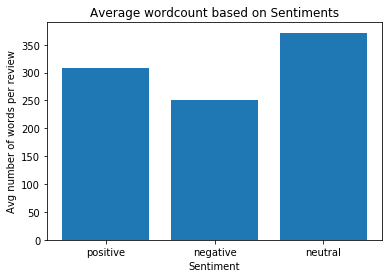

In [60]:
# Plot the statistics

plt.bar(range(len(avg_text_length)), list(avg_text_length.values()), align='center')
plt.title('Average wordcount based on Sentiments')
plt.xticks(range(len(avg_text_length)), list(avg_text_length.keys()))
plt.xlabel('Sentiment')
plt.ylabel('Avg number of words per review')
plt.show()

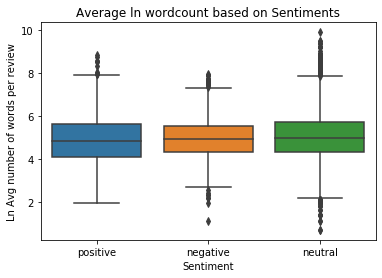

In [58]:
# Create Box plot to better visualize the distribution of wordcounts

sns.boxplot(data = [np.log(positive_wordcount), np.log(negative_wordcount), np.log(neutral_wordcount)])
plt.title('Average ln wordcount based on Sentiments')
plt.xticks(range(len(avg_text_length)), list(avg_text_length.keys()))
plt.xlabel('Sentiment')
plt.ylabel('Ln Avg number of words per review')
plt.show()

<div class="span5 alert alert-success">
<b>Insight:</b>
<ul>
    <li> By looking at the bar graph, neutral reviews are relatively more verbose whereas negative reviews are more curt. That could be sensible since we often don't want to waste our time typing so much comment for a drug we had bad experiences with. Though at the same time, if we observe the log 10 word count distributions from the box plot, it looks as if the three distributions are very similar. To determine if there is difference among the sentiments in terms of word count, we'll conduct a one-way ANOVA test.</li>
</ul>
</div>

In [23]:
# First we test for normality, since one of the assumptions of a one-way ANOVA test is for the samples to be normally distributed

from scipy.stats import normaltest

In [24]:
k2, p = normaltest(positive_wordcount)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: sample comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.61999e-164
The null hypothesis can be rejected


In [25]:
k2, p = normaltest(negative_wordcount)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: sample comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.40462e-150
The null hypothesis can be rejected


In [26]:
k2, p = normaltest(neutral_wordcount)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: sample comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0
The null hypothesis can be rejected


In [27]:
# Since the distributions are not normal, we have to use Kruskal-Wallis H-test tests instead of the ANOVA test

from scipy.stats import kruskal

In [28]:
# Derive result

aov_result = kruskal(positive_wordcount, negative_wordcount, neutral_wordcount)
print(aov_result)

KruskalResult(statistic=11.932513860030038, pvalue=0.002563820038921709)


<div class="span5 alert alert-success">
<ul>
    <li> Since our p-value is very small, we reject the null hypothesis in favor of the alternative hypothesis. Thus, there is a statistically significant difference between the groups</li>
</ul>
</div>

## Innate qualities of drugs

We also notice that we have an extra column in addition to the review text column, and that is information about which drug the review is supposed to be for. Now testing for drug effective is another problem altogether, but I suspect that drugs will have different innate effectiveness. Thus, we will use this section to explore the question of "Do the drugs have innate positivity, negativity or neutrality?"

In [29]:
# Get all of the unique drug names
drug_list = train.drug.unique().tolist()

In [30]:
# Create a dictionary for the positive, negative and neutrality rate of all drugs
positive_rate = {} 
negative_rate = {}
neutral_rate = {}

# Loop through each drug names and identify all the drug's positive/negative/neutral case divided by the sum (for the rate)
for drug in drug_list:
    n_positive = (train[train.drug == drug].sentiment == 0).sum()
    n_negative = (train[train.drug == drug].sentiment == 1).sum()
    n_neutral = (train[train.drug == drug].sentiment == 2).sum()
    positive_rate[drug] = round(n_positive / (n_positive + n_negative + n_neutral),2)
    negative_rate[drug] = round(n_negative / (n_positive + n_negative + n_neutral),2)
    neutral_rate[drug] = round(n_neutral / (n_positive + n_negative + n_neutral), 2)
    

In [31]:
# Sort the dictionary and display the items with highest positive rates

sorted(positive_rate.items(), key = lambda x: x[1], reverse = True)[0:10]

[('nivolumabb', 1.0),
 ('lorlatinib', 0.5),
 ('almita', 0.5),
 ('brolucizumab', 0.5),
 ('ofatumumab', 0.4),
 ('tofacitinib', 0.37),
 ('siponimod', 0.36),
 ('mekinist', 0.33),
 ('dexamethasone implant', 0.33),
 ('macugen', 0.33)]

In [32]:
# Sort the dictionary and display the items with highest negative rates

sorted(negative_rate.items(), key = lambda x: x[1], reverse = True)[0:10]

[('infliximab-dyyb', 1.0),
 ('alunbrig', 1.0),
 ('ketruda', 1.0),
 ('cyramza', 1.0),
 ('aubagio', 0.5),
 ('gefitinib', 0.43),
 ('gilenya', 0.35),
 ('mekinist', 0.33),
 ('ceritinib', 0.33),
 ('arzerra', 0.33)]

In [33]:
# Sort the dictionary and display the items with highest neutral rates

sorted(neutral_rate.items(), key = lambda x: x[1], reverse = True)[0:10]

[('pan-retinal photocoagulation', 1.0),
 ('ipilimumab', 1.0),
 ('ixifi', 1.0),
 ('teriflunomide', 1.0),
 ('zykadia', 1.0),
 ('yervoy', 1.0),
 ('amjevita', 1.0),
 ('pemrolizumab', 1.0),
 ('tafinlar', 1.0),
 ('gilotrif', 1.0)]

<div class="span5 alert alert-success">
<b>Insight:</b>
<ul>
    <li>It looks like the fact that we have different drugs in every list shows that drugs have innate positivity/negativity and neutrality. Thus, we can integrate the drugs as a categorical variable for our model.</li>
</ul>
</div>

## Number of other drug mentioned

Interestingly, different drugs can be mentioned in a drug's review. These drugs are often used as a means of comparison or a list of recommended drugs. It will be interesting to explore whether or not the number of drugs mentioned play a role in the sentiment of the review.

In [34]:
# Extract the number of other drug mentions in review for each sentiments

positive_n_drug = train_processed[train_processed.sentiment == 0].apply(
    lambda row: len([word for word in row['text'].split(' ') if (word in drug_list) and (word not in row['drug'])]), 
    axis=1)

negative_n_drug = train_processed[train_processed.sentiment == 1].apply(
    lambda row: len([word for word in row['text'].split(' ') if (word in drug_list) and (word not in row['drug'])]), 
    axis=1)

neutral_n_drug = train_processed[train_processed.sentiment == 2].apply(
    lambda row: len([word for word in row['text'].split(' ') if (word in drug_list) and (word not in row['drug'])]), 
    axis=1)

In [35]:
# Create a dictionary that gives the other drugs mentioned according to sentiment

avg_drugs_mentioned = {"positive": round(positive_n_drug.mean(),1),
                   "negative": round(negative_n_drug.mean(),1),
                   "neutral": round(neutral_n_drug.mean(),1)}

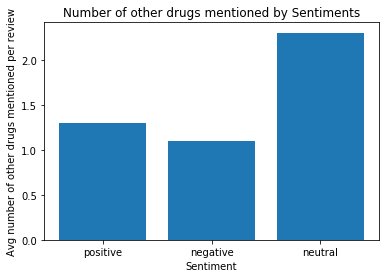

In [62]:
# Plot the statistics

plt.bar(range(len(avg_drugs_mentioned)), list(avg_drugs_mentioned.values()), align='center')
plt.title('Number of other drugs mentioned by Sentiments')
plt.xticks(range(len(avg_drugs_mentioned)), list(avg_drugs_mentioned.keys()))
plt.xlabel('Sentiment')
plt.ylabel('Avg number of other drugs mentioned per review')
plt.show()

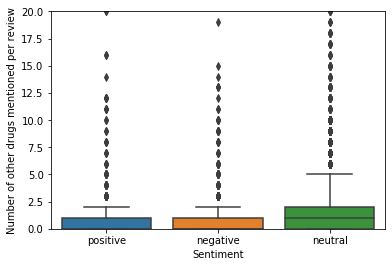

In [37]:
# Create Box plot to better visualize the distributions

sns.boxplot(data = [positive_n_drug, negative_n_drug, neutral_n_drug])
plt.xticks(range(len(avg_drugs_mentioned)), list(avg_drugs_mentioned.keys()))
plt.xlabel('Sentiment')
plt.ylabel('Number of other drugs mentioned per review')
plt.ylim(0,20)
plt.show()

In [38]:
max(neutral_n_drug)

358

<div class="span5 alert alert-success">
<ul>We see that the neutral sentiment very often has more of other drugs mentioned, but all three distributions have a median close to 1 and have a very long right tail, up to 395 other drug mention in one neutral reviews. Before we make any conclusion, it's important to note that neutral sentiment reviews are also generally longer, so we need to adjust for the length of the review.
</ul>
</div>

In [39]:
# Take the adjusted other drugs mentioned arrays

positive_adj_n_drugs = positive_n_drug / positive_wordcount 
negative_adj_n_drugs = negative_n_drug / negative_wordcount
neutral_adj_n_drugs = neutral_n_drug / neutral_wordcount

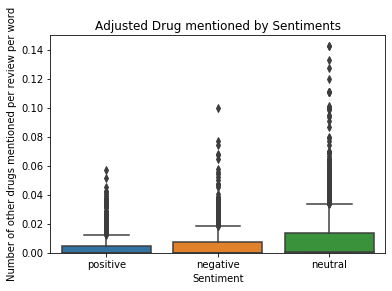

In [61]:
# Create Box plot to better visualize the distributions

sns.boxplot(data = [positive_adj_n_drugs, negative_adj_n_drugs, neutral_adj_n_drugs])
plt.title('Adjusted Drug mentioned by Sentiments')
plt.xticks(range(len(avg_drugs_mentioned)), list(avg_drugs_mentioned.keys()))
plt.xlabel('Sentiment')
plt.ylabel('Number of other drugs mentioned per review per word')
plt.ylim(0,0.15)
plt.show()

<div class="span5 alert alert-success">
<ul>The tail looks less absurd with this adjustment. Clearly, the distribution is non-normal, so we need to conduct the kruskal test again to see if these samples come from the same distribution or if there is significant statistical significant difference between these groups. 
</ul>
</div>

In [41]:
# Derive result

aov_result = kruskal(positive_adj_n_drugs, negative_adj_n_drugs, neutral_adj_n_drugs)
print(aov_result)

KruskalResult(statistic=118.03417931058291, pvalue=2.3399340905790852e-26)


<div class="span5 alert alert-success">
    <b> Insight: </b>
<ul><li>With a very small p-value, we can conclude that the difference is significant. We can thus integrate this insight into our ML model with a feature called n_drug_mentioned (adjusted for review length).</li> 
</ul>
</div>

## Word2Vec visualization

Apart from the meta data, we can use word-embeddings to visualize how close our vocabularies are in proximity to each other and whether or not a word2vec model will be able to distinguish negative words from positive words

In [42]:
# Import modules

from gensim.models import Word2Vec, KeyedVectors
import multiprocessing

In [43]:
%%time

#### Create Word2vec word embeddings
n_dim = 300

sentences = [row.split() for row in train_processed.text]

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=10,
                     window=4,
                     size=n_dim,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

Wall time: 46.7 s


(15389755, 31224900)

In [44]:
# Create list of sample words. Here we will use 2 positive, 2 negative and 2 neutral words
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=4)]
                  for search_term in ['health', 'vaccine','effective','improve', 'bad', 'pain']}
similar_words

{'health': ['healthcare', 'care', 'medical', 'service'],
 'vaccine': ['inactivated', 'attenuate', 'bacillus', 'vaccination'],
 'effective': ['proven', 'efficacious', 'safer', 'well-tolerated'],
 'improve': ['improved', 'health-related', 'impact', 'alleviate'],
 'bad': ['badly', 'depressed', 'feel', 'horrible'],
 'pain': ['spasm', 'cramp', 'discomfort', 'ache']}

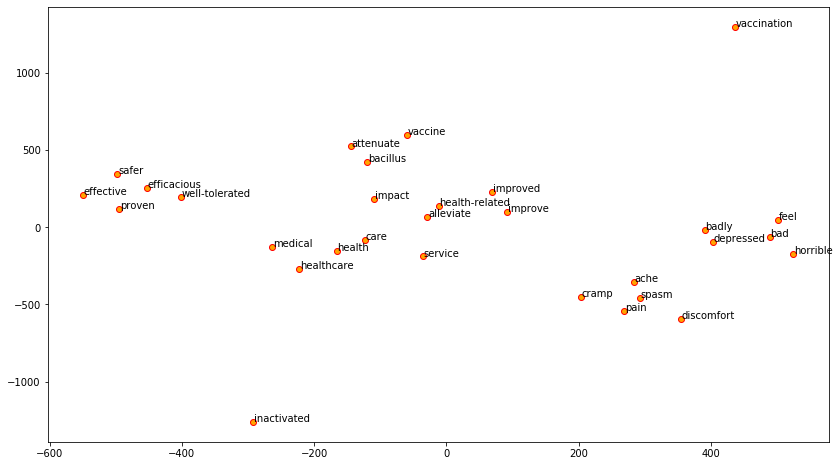

In [45]:
from sklearn.manifold import TSNE

# Create TSNE dimension reduction to visualize results
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

<div class="span5 alert alert-success">
    <b> Insight:</b>
<ul><li>The Word2Vec model seems to be able to moderately distinguish positive and negative connotations very well (grouping words with similar sentiment close together. However, The data might still be noisy due to the fact that non-related drugs may be brought up with completely different sentiments</li> 
</ul>
</div>

## Meta-data feature importance

We can also analyze and reduce meta-data which add more noise to the models using a random forest feature importance

In [46]:
# Set model path

model_dir = os.path.join(os.path.dirname(os.getcwd()), 'Model')

In [47]:
# Import Naive Bayes

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from custom_function.ml import create_classifier, evaluate_classifier, get_model_results
import pickle

In [48]:
# Define X and y

X = meta_features.drop('sentiment', axis = 1)
y = meta_features.sentiment

In [49]:
scaler = StandardScaler()

In [50]:
forest = RandomForestClassifier(n_estimators=10,
                                max_features = 'sqrt')

In [51]:
forest.fit(scaler.fit_transform(X), y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
importances = forest.feature_importances_

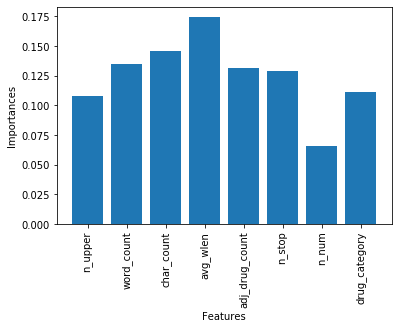

In [53]:
plt.bar(x = X.columns, height = importances)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()